# Numerische Berechnung der Beta, Dispersionsfunktionen

Da der Matrixformalismus eine numerische Berechnung der relevanten Funktionen ermoeglicht soll dies im Folgenden gemacht werden.

Dazu wird zunaechst der Ring des Ringbeschleunigers in seine Komponenten, also primaer FODO-Zellen zerlegt und dann die Beta und Dispersionsfunktion mithilfe der zugehoerigen Transfermatrizen durch die FODO-Zelle propagiert. Dazu sollen zunaechst alle relevanten Transportmatrizen aufgelistet werden.

Der allgemeine Formalismus fuer eine einzige Teilchenbahn ist:

$ \begin{pmatrix}
u_1 \\
u'_1 
\end{pmatrix} = M_{01} 
\begin{pmatrix}
u_0 \\
u'_0
\end{pmatrix}$

Da wir jedoch nicht direkt an der Bahn eines einzelnen Teilchens interressiert sind, sondern an dem Verhalten des Ganzen Teilchenpacketes muss anstelle des Teilchenvektors die Betamatrix gestellt werden. Fuer eine Transportmatrix $M_{01}$ gilt:

$ B_1 = M_{01} B_0 M_{01}^T $

mit

$ B_0 = \begin{pmatrix} \beta_0 & -\alpha_0 \\ -\alpha_0 & \gamma_0 \end{pmatrix}$

wobei $ \beta_0 = \beta(s_0)$ und $\beta(s)$ die Betafunktion und $\beta'(s)$ deren ableitung nach s ist.
Es gilt weiterhin: $\alpha_0 = \alpha(s) = -\frac{\beta'(s)}{2} $ und $\gamma_0 = \frac{1+\alpha^2(s)}{\beta(s)}$

#### Transformationsmatrix fuer eine Driftstrecke
Die Driftstrecke wirkt in gleichem masse auf Auslenkungen in x und in y richtung einer Teilchenbahn und ist definiert als:

$ M_{Dr}(s) = \begin{pmatrix} 1 & s & 0 & 0 \\ 0 & 1 & 0 & 0 \\ 0 & 0 & 1 & s \\ 0 & 0 & 0 & 1 \end{pmatrix} $

Da es im allgemeinen auch interressant ist die Betafunktion sowohl fuer die x als auch die y komponente zu berechnen kann auch die Betamatrix auf eine 4x4 Matrix erweitert werden.

In [39]:
# we are doing matrix multiplication so we are going to need numpy
import numpy as np
import matplotlib.pyplot as plt

def drift_space_transport_matrix(s):
    return np.array([[1, s, 0, 0],
                     [0, 1, 0, 0],
                     [0, 0, 1, s],
                     [0, 0, 0, 1]])

def drift_space_particle_transport(x_0, s):
    m = drift_space_transport_matrix(s)
    return m @ x_0


def drift_space_betamatrix_transport(B_0, s):
    m = drift_space_transport_matrix(s)
    return m @ B_0 @ m.T

#### Transportmatrix fuer einen Quadrupol
Die Quadrupoltransportmatrix ist je nach Quadrupolstaerke in einer der beiden Ebenen fokussierend, waerend es in der anderen ebene defokussierend ist.
Daher auch die etwas kompliziertere Struktur. Alle Matrizen sind so geschrieben, sodass sie fuer alle $s$ gueltig sind, da es dank der in grossen Mengen zur verfuegung stehenden Rechenleistung nicht noetig ist vereinfachungen zu verwenden.

Horizontal fokussierender Quadrupol $k < 0$ mit $\Omega = \sqrt{\lvert k\rvert}s$:

$ M_{QF} = \begin{pmatrix} \cos{\Omega} & \frac{1}{\sqrt{\lvert k \rvert}}\sin{\Omega} & 0 & 0 \\
-\sqrt{\lvert k \rvert} \sin{\Omega} & \cos{\Omega} & 0 & 0 \\
0 & 0 & \cosh{\Omega} & \frac{1}{\sqrt{\lvert k \rvert}} \sinh{\Omega} \\
0 & 0 & \sqrt{\lvert k \rvert} \sinh{\Omega} & \cosh{\Omega} \end{pmatrix} $

Vertikal fokussierender Quadrupol $k > 0$:

$ M_{QD} = \begin{pmatrix} \cosh{\Omega} & \frac{1}{\sqrt{k}}\sinh{\Omega} & 0 & 0 \\
\sqrt{k} \sinh{\Omega} & \cosh{\Omega} & 0 & 0 \\
0 & 0 & \cos{\Omega} & \frac{1}{\sqrt{k}} \sin{\Omega} \\
0 & 0 & -\sqrt{k} \sin{\Omega} & \cos{\Omega} \end{pmatrix} $

In [28]:
def quad_transport_matrix(s, k):
    sk = np.sqrt(np.abs(k))
    a = np.array([[np.cos(sk*s), 1/sk*np.sin(sk*s)],
                  [-sk*np.sin(sk*s), np.cos(sk*s)]])
    b = np.array([[np.cosh(sk*s), 1/sk*np.sinh(sk*s)],
                  [sk*np.sinh(sk*s), np.cosh(sk*s)]])
    # horizontal fokussierend
    
    if k < 0:
        mat = np.block([[a, np.zeros((2, 2))],
                        [np.zeros((2, 2)), b],
                       ])
    # vertikal fokussierend
    else:
        mat = np.block([[b, np.zeros((2, 2))],
                        [np.zeros((2, 2)), a],
                       ])
    return mat

def quad_particle_transport(x_0, s, k):
    m = quad_transport_matrix(s,k)
    return m @ x_0

def quad_betamatrix_transport(B_0, s, k):
    m = quad_transport_matrix(s, k)
    return m @ B_0 @ m.T

#### Transportmatrix fuer einen Dipol
Bei der Transportmatrix eines Dipols muss noch der ablenkwinkel aus der Laenge und dem Ablenkradius errechnet werden.
Es gilt
$ \theta = \frac{s}{\rho} $ wobei $s$ die strecke des Teilchens entlang des Dipols ist.

Ein Dipol wirkt prinzipiell nur auf die Horizontale Bahn des Teilchens, wesshalb die Dipolmatrix asymmetrisch aussieht, wenn sie als 4 x 4 matrix geschrieben wird.

$ M_{Dipol} = \begin{pmatrix} \cos{\theta} & \rho \sin{\theta} & 0 & 0 \\ -\frac{1}{\rho}\sin{\theta} & \cos{\theta} & 0 & 0 \\ 0 & 0 & 1 & s \\ 0 & 0 & 0 & 1\end{pmatrix} $

In [19]:
def dipol_transport_matrix(s, r):
    x = np.array([[np.cos(s/r), r*np.sin(s/r)],
                   [-1/r*np.sin(s/r), np.cos(s/r)]])
    y = np.array([[1, s],
                  [0, 1]])
    return np.block([[x, np.zeros((2, 2))],
                     [np.zeros((2, 2)), y]])

def dipol_particle_transport(x_0, s, r):
    m = dipol_transport_matrix(s, r)
    return m @ x_0

def dipol_betamatrix_transport(B_0, s, r):
    m = dipol_transport_matrix(s, r)
    return m @ B_0 @ m.T

## Berechnung der Dispersionsfunktion
Die Dispersion kann ebenfalls als Matrix formuliert werden. Da die Dispersion in erster linie vom kruemungsradius der Bahn beeinflusst wird, koennen alle magnete ausser der Dipole vernachlaessigt werden. Die Dispersionsmatrizen sind folglich fuer alle strecken identisch zu einer Driftstrecke, ausser beim dipol.

Die Dipol Dispersionsmatrix ist wie folgt definiert.

$ MD = \begin{pmatrix} \cos{\theta} & \rho\sin{\theta} & \rho \left(1-\cos{\theta}\right) \\
-\frac{1}{\rho}\sin{\theta} & \cos{\theta} & \sin{\theta} \\
0 & 0 & 1 \end{pmatrix}$

Sie transportiert den Dispersionsvector

$\vec{D} = \begin{pmatrix} D_0 \\ D'_0 \\ \frac{\Delta p}{p_0} \end{pmatrix}$ 

entlang des Maschinenorbits

In [20]:
def dipol_dispersion_transport(d_0, s, r):
    m = np.array([[np.cos(s/r), r*np.sin(s/r), r*(1-np.cos(s/r))],
                     [-(1/r)*np.sin(s/r), np.cos(s/r), np.sin(s/r)],
                     [0, 0, 1]
                    ])
    return m @ d_0

def quad_dispersion_transport(d_0, s):
    m = np.array([[1, s, 0],
                  [0, 1, 0],
                  [0, 0, 1]])
    return m @ d_0

def drift_dispersion_transport(d_0, s):
    return quad_dispersion_transport(d_0, s)

## Test der Funktionen
Im Folgenden sollen die oben beschriebenen Funktionen getestet werden.
Zunaechst soll eine bahnkurve fuer einen Dipol berechnet werden, wobei eine 180 grad wende gemacht werden soll. Das Teilchen soll dabei lediglich ein klein wenig von der sollbahn versetzt sein und parallel zur sollbahn fliegen

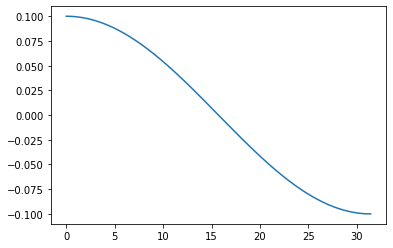

In [25]:
r = 10
s_max = np.pi * r
s = np.linspace(0, s_max, 1000)
x_0 = [0.1, 0, 0, 0] 

x_s = [dipol_particle_transport(x_0, s_i, r)[0] for s_i in s]
plt.plot(s, x_s)

wie wir sehen hat die abweichung gerade das vorzeichen gewechselt, genau wie erwartet
fuer den quadrupol kann nun geprueft werden, ob zwei parallele strahlen vor dem quadrupol nach dem quadrupol in der einen ebene zusammenlaufen waehrend sie in der anderen ebene gestreut werden. Es soll daran erinnert werden, dass $\frac{1}{f} = -kl$

[ 0.09016556 -0.00966998  0.          0.        ]
[-0.09016556  0.00966998  0.          0.        ]
[0.         0.         0.11016778 0.01033668]
[ 0.          0.         -0.11016778 -0.01033668]


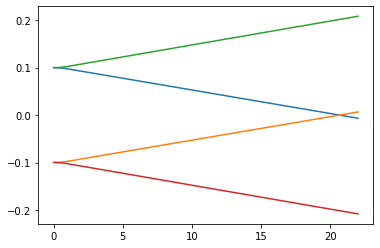

In [40]:
# horizontal fokussierend, vertikal defokussierend
k = -0.05
l = 1
s_max = -1/(k*l) + l
s_in_quad = np.linspace(0, l, 1000)
s_outside_quad = np.linspace(0, s_max, 1000)
x = [[0.1, 0, 0, 0], [-0.1, 0, 0, 0]]
y = [[0, 0, 0.1, 0], [0, 0, -0.1, 0]]
tracks = [[], [], [], []]

for i, particle in enumerate(x):
    for s_i in s_in_quad:
        tracks[i].append(quad_particle_transport(particle, s_i, k)[0])
    x[i] = quad_particle_transport(particle, l, k)

for i, particle in enumerate(y):
    for s_i in s_in_quad:
        tracks[i+len(x)].append(quad_particle_transport(particle, s_i, k)[2])
    y[i] = quad_particle_transport(particle, l, k)
    
print(quad_particle_transport(x[0], l, k))
print(quad_particle_transport(x[1], l, k))
print(quad_particle_transport(y[0], l, k))
print(quad_particle_transport(y[1], l, k))

for i, particle in enumerate(x):
    for s_i in s_outside_quad:
        x_i = drift_space_particle_transport(particle, s_i)
        tracks[i].append(x_i[0])
        #print(x_i)

for i, particle in enumerate(y):
    for s_i in s_outside_quad:
        x_i = drift_space_particle_transport(particle, s_i)
        tracks[i+len(x)].append(x_i[2])
        #print(x_i[2])

s_outside_quad += l
s = np.concatenate((s_in_quad, s_outside_quad), axis=0)
for track in tracks:
    plt.plot(s, track)
plt.show()

jetzt wo wir wissen, dass die entsprechenden Funktionen auch das tun was sie sollen, koennen wir inzwischen bereits Teilchenbahnen durch den Beschleuniger verfolgen. Als letztes muss noch die  Dispersionsfunktion getestet werden. Wir nehmen an, dass die Dispersionsfunktion nur in Dipolen eine evolution erfaehrt
Es soll also jetzt die dispersionsentwicklung in einem Dipol betrachtet werden.

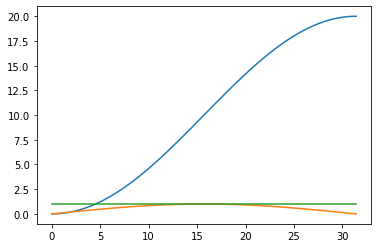

In [50]:
r = 10
s_max = np.pi * r
s = np.linspace(0, s_max, 1000)
d_0 = [0.00, 0.00, 1] 

d_s = [dipol_dispersion_transport(d_0, s_i, r) for s_i in s]
plt.plot(s, d_s)
plt.show()

Wie man sehen kann ist die Dispersionsabweichung periodisch ist was zumindest fuer den Fall einer Kreisbahn immerhin sinnvoll erscheint.